## Load in Image

This dataset is a sample from a larger research project.
The sample comprises of 16 micrographs.
Each micrograph was taken at different temperatures/pressure stored as seperate .jpg files.

## Aims

A program that can :
 
- `Upload`: an image of a micrograph 
- `Crop`: the image to only relevant area
- `Process`: Take scale bar to aid in comparison of images 
- `Process`: Identify indiviual Hydrides in microstructure  

## Import Packages

In [29]:
# We import the packages we need
#Libraries and packages
import re
from matplotlib import pyplot as plt
from PIL import Image

import os, os.path
import matplotlib.axes

#Image library
import matplotlib.image as mpimg

# And also we import the functions we have created, which are in the packages folder
from packages import plot_image

# Thresholding
from ipynb.fs.full.Otsu_Thresholding import Otsu

ModuleNotFoundError: No module named 'ipynb'

## Import the images from github

- Import image [.jpg image] 
- Transpose the image to make the radial direction vertical. 
- Crop scale bar from image and/or crop image to a specific location. 
- Input Scale Bar Value, the scale bar will then be calculated.

In [30]:
def sorted_aphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

The data should be placed in a sub-directory called `Micrographs`.

In [36]:
mypath = './Micrographs/'
from os import listdir
def_files = sorted_aphanumeric(listdir(mypath))

In [38]:
len(def_files)

16

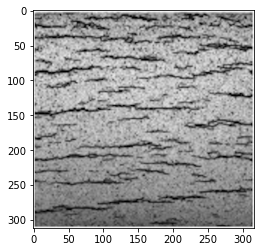

In [42]:
img = mpimg.imread('./Micrographs/chu1.jpg')
imgplot = plt.imshow(img)

In [2]:
# Introduce here the path where the images are located
images_path = "C:\\Users\Laura\Dropbox (The University of Manchester)\Software Engineering practice\Hydride-Connect-Group-2\Job_script\Micrographs"

In [16]:
mypath.plotim(mypath, valid_images= [".jpg",".gif",".png",".tga"])

AttributeError: 'str' object has no attribute 'plotim'

## Image Processing

Produce a monochrome image where the hydrides are white, and the matrix is black. 

Crop image to remove scale bar.

Remove black background on micrograph

## Thresholding

Thresholding - Remove un-wanted features such as X and Y from images.
Side by side comparison to original image and image after thresholding method.
Use 3 different thresholding method and see which one works best .

In [ ]:
Otsu_Result = Otsu(ImgProcessed)

## Connecivity of Microstructure 

Asses interconnectivity between hydrides in the radial direction